#Setup and Intro to OpenAI gym


In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules


if IS_COLAB or IS_KAGGLE:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -U tf-agents pyvirtualdisplay
    %pip install -U gym~=0.21.0
    %pip install -U gym[box2d,atari,accept-rom-license]

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
import gym

In [ ]:
env = gym.make('CartPole-v1',render_mode="rgb_array")

In [ ]:
obs = env.reset()

In [ ]:
env.np_random.random(32)
obs

In [ ]:
try:
  import pyvirtualdisplay
  display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
  print('worked')
except ImportError:
  pass

worked


In [ ]:
img = env.render()

In [ ]:
img.shape

In [ ]:
def plt_env(env):
  plt.figure(figsize=(5,4))
  img = env.render()
  plt.imshow(img)
  plt.axis("off")
  return img 

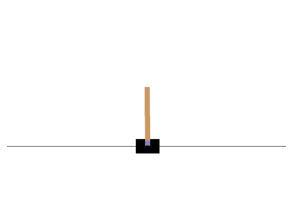

In [ ]:
plt_env(env)
plt.show()

In [ ]:
env.action_space

Discrete(2)

In [ ]:
action = 0
stats=env.step(action)
obs = stats[0]
reward = stats[1]
done = stats[2]
info = stats[3]

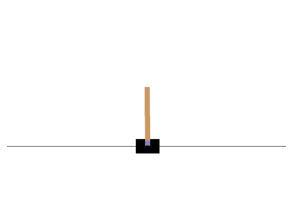

In [ ]:
plt_env(env)
plt.show()

In [ ]:
save_fig("cart_pole_plot")

Saving figure cart_pole_plot


<Figure size 432x288 with 0 Axes>

In [ ]:
print(obs)
print(reward)
print(done)
print(info)

[ 0.02018281 -0.15591627 -0.01105781  0.30456463]
1.0
False
False


In [ ]:
if done:
  obs = env.reset()

# Creating a Simple-Hardcoded Policy

In [ ]:
def basic_policy(obs):
  angle = obs[2]
  return 0 if angle < 0 else 1 

In [ ]:
import array
from numpy.core.memmap import dtype

env.np_random.random(32)
totals=[] 

for episode in range(500):
  episode_rewards = 0 
  obs = env.reset()
  obs = np.array(obs[0])

  for step in range(200):
    #action will either be 0 or 1 
    action = basic_policy(obs)
    #get all information from each action 
    stats = env.step(action)
    obs = np.array(stats[0])
    reward = stats[1]
    done = stats[2]
    info = stats[3]

    episode_rewards += reward 

    if done: 
       break
       
  totals.append(episode_rewards) 

In [ ]:
print('mean',np.mean(totals) ,np.std(totals),np.min(totals),np.max(totals))


mean 41.758 8.561976173758017 24.0 72.0


In [ ]:
env.np_random.random(32)

frames = [] 

obs = env.reset()
obs = np.array(obs[0])
for step in range(200):
  img = env.render()
  frames.append(img)
  action = basic_policy(obs)

  stats=env.step(action)
  obs = np.array(stats[0])
  reward = stats[1]
  done = stats[2]
  info = stats[3]

  if done: 
    break

# Visualization

In [ ]:
def update_scene(num,frames,patch): 
  patch.set_data(frames[num])
  return patch

def plot_animation(frames,repeat=False,interval=40):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(fig,update_scene, fargs=(frames,patch),
                                 frames=len(frames),repeat=repeat,interval=interval)
  
  plt.close()
  return anim 

In [ ]:
plot_animation(frames)

# Neural Network Policy 

#### Use the import statements and plotting functions from the previous post 

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.rand(42)
#this is the observation space 
num_inputs = 4 

In [ ]:
%%html 
 <style>
div.info {    
    background-color:#D6EAF8;
    border-color: #3498DB;
    border-left: 5px solid #3498DB;
    padding: 0.5em;
    }
 </style>

<div class=info>
If changing the parameters of the model, make sure to clear session before retraining the model 
</div>



In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(20,activation="relu",input_shape=(num_inputs,)),
    keras.layers.Dense(5,activation="relu"),
    keras.layers.Dense(1,activation="sigmoid"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                100       
                                                                 
 dense_1 (Dense)             (None, 5)                 105       
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


The input for our model is going to the environment's observations: obs = [x,x,x,x] and the output will the action that is going to be taken by the cart (either 0 or 1).
Since there are only two possible actions, we only need one output neuron using the sigmoid activation function to represent the action that the cart will take. If there were more than two actions that we could take, then each action would be represented by a neuron and we would use the softmax activation function. 

In the code below, we decide our action based on random probability. For example let's say the randomly generated probability is .40 and the probability of going left generated by the model is 0.50. We have a statement below that compares these two probabilites. Since .40 > .50 is a false statement, we convert our boolean to the integer 0 and our action is to go left. 

We make our decisions based on this random probability because we want to find the right balance between exploring new actions and exploiting actions that we already know work well. Imagine you go to a cafe and randomly select a coffee. If you like it, the probability that you order it again next time you go is increased. However, you shouldn't increase that probability to 100% because there might be other coffees to try that are even better than the first. 

In [ ]:
def render_policy(model,max_steps=200,seed=42): 
  frames = [] 
  env = gym.make("CartPole-v1",render_mode="rgb_array")
  np.random.seed(seed)
  #reset the environment 
  obs = env.reset()
  obs = np.array([obs[0]])
  reward = 0 
  #keep track of how many consectuive times pole is vertical 
  totals = 0 
  for step in range(max_steps):
    frames.append(env.render())
    left_prob = model.predict(obs)
    #print('left_prob',left_prob)
    #generate random number  
    p = np.random.rand()
    #print('p',p)
    #turn boolean value into integer (ACTION  = TRUE:1 OR FALSE:0)
    action = int(p>left_prob)
    #print('action',action)
    stats = env.step(action)
    obs = np.array([stats[0]])
    
    reward = stats[1]
    done = stats[2]
    info = stats[3]
    totals+= reward 
    if done: 
      break
  env.close()
  return frames,totals

For our cart-pole environment, we can ignore past observations and actions because at each step we can see the environments full state. 

For example: If the environment only revealed the cart's position and not the velocity, you would have to consider past and current observations in order to determine the current velocity. We do not have to worry about this in our case. 

Lets see how well a randomly initialized policy network performs: 

In [ ]:
frames,totals = render_policy(model)
plot_animation(frames)

1/1 [==============================] - 0s 19ms/step
p 0.3745401188473625
left_prob [[0.49724284]]
action 0
1/1 [==============================] - 0s 20ms/step
p 0.9507143064099162
left_prob [[0.50142497]]
action 1
1/1 [==============================] - 0s 19ms/step
p 0.7319939418114051
left_prob [[0.4971607]]
action 1
1/1 [==============================] - 0s 21ms/step
p 0.5986584841970366
left_prob [[0.4774564]]
action 1
1/1 [==============================] - 0s 29ms/step
p 0.15601864044243652
left_prob [[0.4559578]]
action 0
1/1 [==============================] - 0s 24ms/step
p 0.15599452033620265
left_prob [[0.47929704]]
action 0
1/1 [==============================] - 0s 23ms/step
p 0.05808361216819946
left_prob [[0.4979668]]
action 0
1/1 [==============================] - 0s 22ms/step
p 0.8661761457749352
left_prob [[0.5000971]]
action 1
1/1 [==============================] - 0s 21ms/step
p 0.6011150117432088
left_prob [[0.49776265]]
action 1
1/1 [==============================] - 

The network here is able to keep the pole vertical for 51 consectutive steps which is an improvement over the previous hard-coded policy! Woo! 

In [ ]:
print(totals)

51.0
